In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np

import os
import glob
from pathlib import Path
import torch
import network_utils as networkUtils

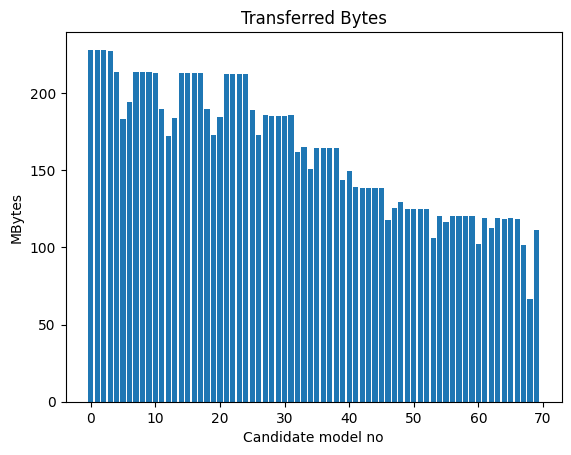

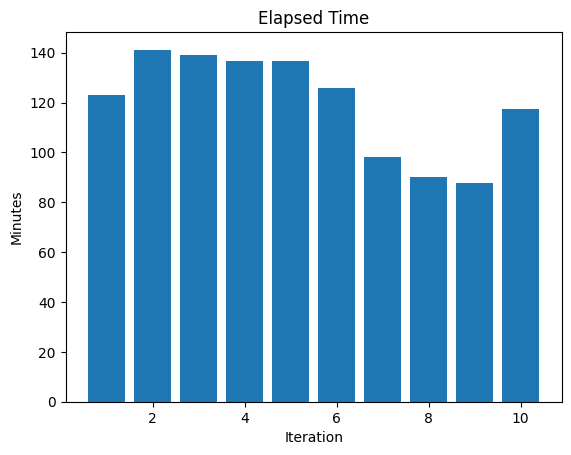

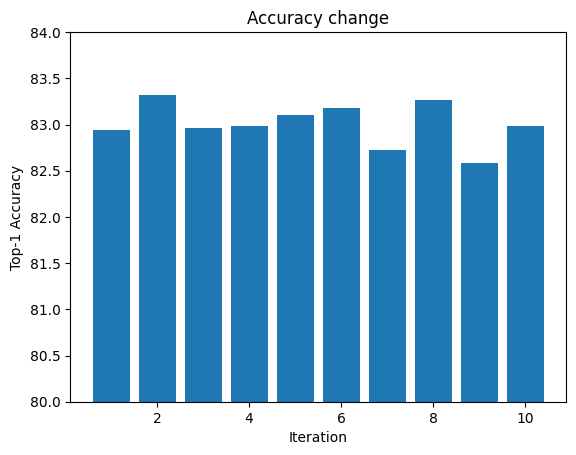

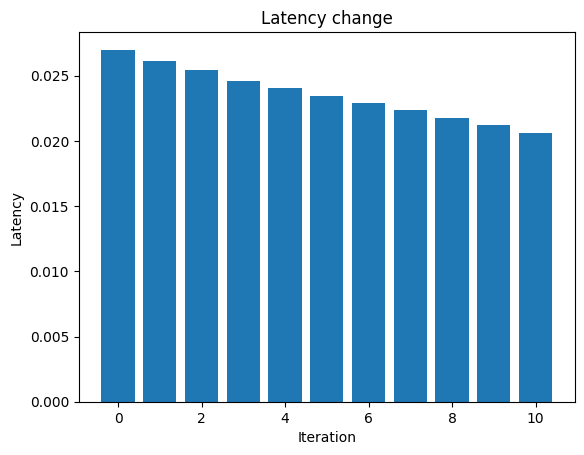

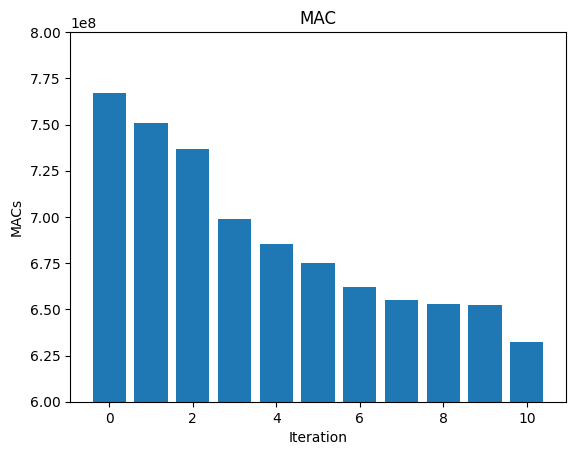

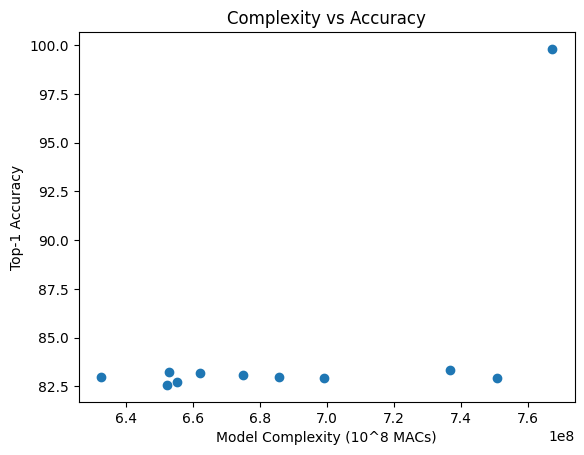

In [27]:
parent_folder = "models/alexnet/fed/test-cpu-4-prune-by-latency"

transferred_bytes = [int(line.split(" : ")[-1])/1000000 for line in list(filter(lambda x: "Size of the encoded model :" in x, latency_logs.split("\n")))]

plt.bar(np.arange(len(transferred_bytes)),transferred_bytes)
plt.xlabel("Candidate model no")
plt.ylabel("MBytes")
plt.title("Transferred Bytes")
plt.show()

latency_logs = open(os.path.join(parent_folder,"logs.txt"),"r").read()
latency_logs

elapsed_times = [float(line.split(" ")[-2])/60 for line in list(filter(lambda line: "Iteration" in line and "finished" in line, latency_logs.split("\n")))]
idx = np.arange(1,len(elapsed_times)+1)

#Elapsed Time
plt.bar(idx, elapsed_times)
plt.xlabel("Iteration")
plt.ylabel("Minutes")
plt.title("Elapsed Time")
plt.show()

#Accuracy vs Latency
latency_best_models = pd.read_csv(os.path.join(parent_folder,"master","history.txt"), delimiter=",")

plt.bar(latency_best_models["Iteration"][1:], latency_best_models["Accuracy"][1:])
plt.ylim(80,84)
plt.xlabel("Iteration")
plt.ylabel("Top-1 Accuracy")
plt.title("Accuracy change")
plt.show()

plt.bar(latency_best_models["Iteration"], latency_best_models["Resource"])
plt.xlabel("Iteration")
plt.ylabel("Latency")
plt.title("Latency change")
plt.show()

#Best model each iteration
model_paths = glob.glob(os.path.join(parent_folder,"master","*.pth.tar"))

flops_arr = []
idx = []

for model_path in model_paths:
    model = torch.load(model_path)
    network_utils = networkUtils.__dict__["alexnet"](model, (3,224,224), "data/Cifar10/server/")
    network_def = network_utils.get_network_def_from_model(model)
    flops = network_utils._compute_weights_and_flops(network_def)
    total_flops = flops[1] + flops[3]
    flops_arr.append(total_flops)
    idx.append(int(Path(model_path).stem.split("_")[1]))

plt.bar(idx, flops_arr)
plt.ylim(6*10**8,8*10**8)
plt.xlabel("Iteration")
plt.ylabel("MACs")
plt.title("MAC")
plt.show()

#Accuracy vs MAC
flops_ordered = [x for y, x in sorted(zip(idx, flops_arr))]
acc = latency_best_models["Accuracy"].tolist()

plt.scatter(flops_ordered, acc)
plt.ylabel("Top-1 Accuracy")
plt.xlabel("Model Complexity (10^8 MACs)")
plt.title("Complexity vs Accuracy")
plt.show()